In [1]:
import torch
import torchvision
from torch.nn import functional as F
import torch.nn as nn
from env import Name, MazeEnv
from model import LSTM
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt

# Load pretrained resnet

In [39]:
resnet18 = torchvision.models.resnet18(pretrained=True)
modules = list(resnet18.children())[:-1]
img_encoder = nn.Sequential(*modules)
img_encoder.eval()
for p in img_encoder.parameters():
    p.requires_grad = False


# Train

In [46]:
lr = 1e-4

agent = LSTM(hidden_size=256)
optimizer = torch.optim.RMSprop(agent.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

losses = []
n_train = 20000

agent.train()
mem_state = agent.get_init_states()
for i in tqdm(range(n_train)):
    task = MazeEnv()
    solution = task.get_solution()
    if solution == None:
        continue
  #  mem_state = agent.get_init_states()
    mem_state = mem_state[0].detach(), mem_state[1].detach()
    p_action = torch.zeros([1, 1, 4])
    loss = 0
    for target in solution:
        img = task.img().unsqueeze(0)
        feature = img_encoder(img).view(1, 1, -1)
        logit, mem_state = agent(feature, p_action, mem_state)
        logit = logit.squeeze(0)
        
        loss += criterion(logit, torch.tensor([target]))
        
        p_action = torch.eye(4)[int(target)].view(1, 1, -1)
        task.step(int(target))
        
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        torch.save(agent.state_dict(), 'checkpoint/rnn_%d' % (i + 1))
        

100%|█████████████████████████████████████| 20000/20000 [09:26<00:00, 35.31it/s]


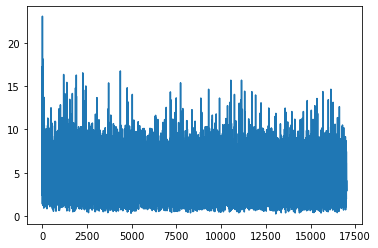

In [47]:
plt.plot(losses)

# Test
Random model: 4%

In [6]:
testset = [MazeEnv() for _ in range(500)]

In [ ]:
agent = LSTM(hidden_size=256)
path = 'checkpoint/rnn_2000'
agent.load_state_dict(torch.load(path))
agent.eval()

limit = 15
correct = 0
n_test = 100
for i in tqdm(range(n_test)):
    task = testset[i]
    mem_state = agent.get_init_states()
    p_action = torch.zeros([1, 1, 4])
    for _ in range(limit):
        img = task.img().unsqueeze(0)
        feature = img_encoder(img).view(1, 1, -1)
        logit, mem_state = agent(feature, p_action, mem_state)
        # logit = logit.squeeze(0)
        # prob = F.softmax(logit, dim=-1)
        # action = prob.multinomial(num_samples=1).item()      
        logit = logit.flatten()
        action = logit.argmax().item()
        reward = task.step(action)
        if reward == 0:
            correct += 1
            break
        p_action = torch.eye(4)[action].view(1, 1, -1)
    task.reset()
print('Success rate %.2f%%' % (correct / n_test * 100) )
        

 42%|█████████████████▋                        | 42/100 [00:02<00:03, 15.61it/s]

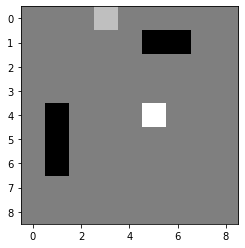

In [66]:
plt.imshow(img.squeeze(0).permute(1,2,0))

In [62]:
p_action

tensor([[[0., 0., 1., 0.]]])

# Other


In [96]:
a = 0
total = 0
for i in range(1000):
    task = MazeEnv()
    solution = task.get_solution()
    if solution != None:
        total += 1
print(total / 1000)


0.851
